In [1]:
import box_world as bw
import data
from pyDatalog import pyDatalog as pyd
from utils import assert_equal

In [44]:
pyd.clear()
pyd.create_terms('action', 'held_key', 'domino', 'neg_held_key', 'neg_domino')
pyd.create_terms('X', 'Y')
+ domino('A', 'B')
+ domino('B', 'C')
held_key(Y) <= held_key(X) & domino(X, Y) & action(Y)
neg_held_key(X) <= held_key(X) & domino(X, Y) & action(Y)
+ held_key('A')
+ action('B')
print(held_key(X))



X
-
A
B


In [2]:
env = bw.BoxWorldEnv(seed=1)

In [3]:
traj = bw.generate_traj(env)

In [4]:
obs = traj[0][0]

In [5]:
tens = data.obs_to_tensor(obs)

In [6]:
def abstractify(obs):
    dominoes = bw.get_dominoes(obs)
    held_key = bw.get_held_key(obs)
    return [held_key] + sorted([s.upper() for s in dominoes.keys()], key=lambda s: (len(s), s))

In [7]:
%matplotlib inline

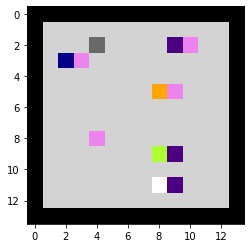

In [8]:
bw.render_obs(obs)

In [9]:
abs_obs = abstractify(obs)
print(abs_obs)

[None, '.', 'T', '*Q', 'ET', 'IQ', 'PT', 'QT']


In [10]:
def transition(abs_obs, abs_action):
    '''
    abs_obs: list of strings
    abs_action: a single letter of the color key we want to move to
    returns a new abs_obs.
    '''
    held_key = abs_obs[0]
    assert '.' == abs_obs[1]
    targets = [x for x in abs_obs[1:] if x[0] == abs_action]
    assert len(targets) == 1
    target = targets[0]
    new_dominoes = abs_obs[1:]
    if len(target) == 1:
        # open key
        new_held_key = target
        new_dominoes.remove(target)
    else:
        if held_key == target[1]:
            new_held_key = target[0]
            new_dominoes.remove(target)
        else:
            new_held_key = held_key
    
    new_abs_obs = [new_held_key] + new_dominoes
    return new_abs_obs

In [11]:
abs_obs2 = transition(abs_obs, 'T');
print(abs_obs2)

abs_obs3 = transition(abs_obs2, 'E')
print(abs_obs3)

['T', '.', '*Q', 'ET', 'IQ', 'PT', 'QT']
['E', '.', '*Q', 'IQ', 'PT', 'QT']


In [53]:
def abstractify_datalog(obs):
    dominoes = list(bw.get_dominoes(obs).keys())
    dominoes = [d.lower()[::-1] for d in dominoes]
    print(dominoes)
    held_key = bw.get_held_key(obs)

    # the agent
    dominoes.remove('.')
    # sort dominoes by length, then alphabetically
    dominoes = sorted(dominoes, key=lambda s: (len(s), s)) 
    # if there's an open key, treat it as a held key
    if len(dominoes) > 0 and len(dominoes[0]) == 1:
        assert held_key is None
        held_key = dominoes[0]
        dominoes = dominoes[1:]

    # map each domino from e.g. 'AB' to ('A', 'B')
    dominoes = [tuple(domino) for domino in dominoes]
    
    if held_key is None:
        held_keys = []
    else:
        held_keys = [(held_key,)]

    out = {}
    if held_keys:
        out['held_key'] = held_keys
    if dominoes:
        out['domino'] = dominoes
    return out

In [54]:
abstractify_datalog(obs)

['.', 'tq', 'tp', 'te', 't', 'qi', 'q*']


{'held_key': [('t',)],
 'domino': [('q', '*'), ('q', 'i'), ('t', 'e'), ('t', 'p'), ('t', 'q')]}

In [55]:
def get_post_transition_facts():
    """
    returns dict of facts. key is the predicate and values are list of arg tuples
    """
    all_facts = {}
    # action facts don't get passed on
    for predicate in [held_key, domino, neg_held_key, neg_domino]:
        for arity in [1, 2]:
            try:
                args = [X, Y] if arity == 2 else [X]
                facts = predicate(*args).ask()
                all_facts[str(predicate)] = facts
            except AttributeError:
                pass
    
    neg_pairs = [('neg_held_key', 'held_key'),
                  ('neg_domino', 'domino')]
    for neg_predicate, predicate in neg_pairs:
        if neg_predicate in all_facts:
            for args in all_facts[neg_predicate]:
                if args in all_facts[predicate]:
                    print(f'removing fact {predicate}({args})')
                    all_facts[predicate].remove(args)
                    if len(all_facts[predicate]) == 0:
                        del all_facts[predicate]
            del all_facts[neg_predicate]
                    
    return all_facts

def transition_datalog(abs_obs: dict[str, list[tuple[str, str]]], abs_action: tuple[str]):
    '''
    abs_obs: dict of facts, {'predicate': [args]}
    abs_action: a tuple of args for the built-in 'action' predicate
    returns a new abs_obs.
    '''
    pyd.clear()
    pyd.create_terms('X', 'Y', 'held_key', 'domino', 'action', 'neg_held_key', 'neg_domino')
    + action(*abs_action)
    if 'held_key' in abs_obs:
        for args in abs_obs['held_key']:
            + held_key(*args)
    if 'domino' in abs_obs:
        for args in abs_obs['domino']:
            + domino(*args)
            
    held_key(Y) <= held_key(X) & domino(X, Y) & action(Y)
    neg_held_key(X) <= held_key(X) & domino(X, Y) & action(Y)
    neg_domino(X, Y) <= held_key(X) & domino(X, Y) & action(Y)
    
    return get_post_transition_facts()

In [66]:
env = bw.BoxWorldEnv()
# trajs = [bw.generate_traj(env) for _ in range(10)]
# for traj in trajs:
    # states, moves = traj
    # check_traj(states, moves)
states, moves = bw.generate_traj(env)
check_traj(states, moves)

[0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2]
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', 'n', '.']
['l*', 'nl', '.']
['l*', 'nl', '.']
['l*', 'nl', '.']
['l*', 'nl', '.']
['l*', 'nl', '.']
['l*', 'nl', '.']
['l*', 'l', '.']
['l*', '.']
['l*', '.']
['l*', '.']
['l*', '.']
['l*', '.']
['l*', '.']
['*', '.']
['.']
[{'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l

TypeError: 'int' object is not subscriptable

In [64]:
def check_traj(states, moves):
    print(moves)
    abs_states = [abstractify_datalog(state) for state in states]
    print(abs_states)
    abs_moves = [(move[0].lower(), ) for move in moves]
    for i, (abs_state, abs_move) in enumerate(zip(abs_states, abs_moves)):
        abs_state2 = transition_datalog(abs_state, abs_move)
        # print(f'{abs_state2=}, {abs_states[i+1]=}')
        assert_equal(abs_state2, abs_states[i+1])

In [58]:
check_traj(states, moves)

['lN', '*L']
['l*', 'nl', 'n', '.']
['l*', '.']
['.']
[{'held_key': [('n',)], 'domino': [('l', '*'), ('n', 'l')]}, {'held_key': [('l',)], 'domino': [('l', '*')]}, {'held_key': [('*',)]}]
removing fact held_key(('n',))
removing fact domino(('n', 'l'))
abs_state2={'held_key': [('l',)], 'domino': [('l', '*')]}, abs_states[i+1]={'held_key': [('l',)], 'domino': [('l', '*')]}
removing fact held_key(('l',))
removing fact domino(('l', '*'))
abs_state2={'held_key': [('*',)]}, abs_states[i+1]={'held_key': [('*',)]}
